In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Metropolis-Hastings algorithm for simulation of protein interaction

#### Goals and questions
- Define the interaction matrix randomly (+) Is it better if I define it one time for all of the samples or randomly set it every time I calculate the Boltzmann factor?
- Implement covariances, MI and others and plot the figure 3 figures (-)
- How do we calculate TP fraction?

#### Further exploration:
- Cross attention on two different sequences 
- Read the notes sent by Luca 

In [115]:
def set_interaction_mat(size, prob=[0.5,0.5]):
    J = np.random.choice([0,1],(size,size),p=prob) # interaction matrix
    J = (J.T + J)/2
    return J

def energy(x, T, J):
    # Function that calculates hamiltonian of the sequence and calculates Boltzmann value
    # x: sequence of spins
    # T: temperature
    total_energy = 0
    for i in range(len(x)):
        for j in range(i+1,len(x)):
            total_energy-=J[i,j]*x[i]*x[j]
    return np.exp(-total_energy/T)

def proposed_sequence(x, num_of_flips, prob):
    '''
    Function:
        Flip one of the spins in the sequence at random
    Args:
        x: sequence of spins 
    '''
    # Determine the indices to consider for flipping
    indices = np.random.choice(len(x), num_of_flips)
    # Generate random numbers for each chosen index to decide if a flip should occur
    flip_decisions = np.random.uniform(0, 1, size=num_of_flips) < prob
    # Apply flips where decided
    x[indices[flip_decisions]] *= -1
    return x

In [177]:
def mcmc_updater(curr_state, curr_energy, 
      energy, proposed_sequence, J, num_of_flips = 5, T=1.0):
    """ Propose a new state and compare the likelihoods
    
    Given the current state (initially random), 
      current likelihood, the likelihood function, and 
      the transition (proposed) state, `mcmc_updater` generates 
      a new sequence, evaluates its Boltzmann factor, compares that to the current 
      state's Boltzmann factor with a threshold sampled from Normal dsitribution, 
    then it returns new or current state in the MCMC chain.

    Args:
        curr_state (float): the current parameter/state value
        curr_likelihood (float): the current likelihood estimate
        energy (function): a function handle to compute Boltzmann energy distribution factor
        proposed_sequence (function): a function handle to compute the 
          next proposed state
        T (float/int): the temperature value of the system

    Returns:
        (tuple): either the current state or the new state
          and its corresponding likelihood
    """
    # Generate a proposal state using the proposal distribution
    # Proposal state == new guess state to be compared to current
    prob =  1.0 - np.exp(-2.0 *1/T)
    prop_state = proposed_sequence(curr_state, num_of_flips,prob)
    print("proposed state: ",prop_state, prop_state.sum())

    # Calculate the acceptance criterion
    prop_energy = energy(prop_state, T, J)
    #print("current energy: ", curr_energy)
    #print("proposed energy: ", prop_energy)

    if (prop_energy - curr_energy < 0) and (np.random.uniform(0, 1) < prob):
      # np.exp(-2*(prop_energy-curr_energy)/T)
      # Generate a random number between 0 and 1 for acceptance entropy
      # If the acceptance criterion is greater than the random number,
      # accept the proposde state as the current state
        return prop_state, prop_energy
    # Else
    return curr_state, curr_energy

In [178]:
def metropolis_hastings(
        energy, proposed_sequence, size, 
        num_samples, num_iters=10, burnin=0.2, T=1.0):
    """ Compute the Markov Chain Monte Carlo

    Args:
        likelihood (function): a function handle to compute the likelihood
        proposal_distribution (function): a function handle to compute the 
          next proposal state
        initial_state (list): The initial conditions to start the chain
        num_samples (integer): The number of samples to compte, 
          or length of the chain
        burnin (float): a float value from 0 to 1.
          The percentage of chain considered to be the burnin length
        T (float/int): the temperature value of the system

    Returns:
        samples (list): The Markov Chain,
          samples from the posterior distribution
    """
    samples = []
    initial_states = []
    track_mag = np.zeros((num_samples, num_iters))
    # The number of samples in the burn in phase
    idx_burnin = int(burnin * num_samples)
    J = set_interaction_mat(size)

    for i in range(num_samples):
        # The proposal distribution sampling and comparison
        #   occur within the mcmc_updater routine

        # We change J since we consider each sequence 
        # to be an different proteins with their individual 
        initial_state = np.random.choice([-1, 1], size=size)

        # Set the current state to the initial state
        curr_state = initial_state
        curr_energy = energy(curr_state, T, J)
        print("new sample: ",i)
        for j in range(num_iters):
          print("current state: ",curr_state, curr_state.sum())
          curr_state, curr_energy = mcmc_updater(
              curr_state=curr_state,
              curr_energy=curr_energy,
              energy=energy,
              proposed_sequence=proposed_sequence,
              J = J,
              num_of_flips = 10,
              T = T
          )
          #print(curr_energy)
          track_mag[i,j] = curr_state.sum()

        # Append the current state to the list of samples
        if i >= idx_burnin:
            # Only append after the burnin to avoid including
            #   parts of the chain that are prior-dominated
            initial_states.append(initial_state)
            samples.append(curr_state)
    return samples, initial_states, J, track_mag

new sample:  0
current state:  [-1  1 -1 -1  1  1  1 -1  1 -1 -1 -1 -1  1  1 -1 -1 -1  1 -1] -4
proposed state:  [-1  1 -1 -1 -1  1  1 -1  1 -1 -1 -1 -1  1 -1 -1 -1 -1  1 -1] -8
current state:  [-1  1 -1 -1 -1  1  1 -1  1 -1 -1 -1 -1  1 -1 -1 -1 -1  1 -1] -8
proposed state:  [-1  1 -1 -1 -1 -1  1 -1 -1  1  1 -1 -1  1 -1 -1  1  1  1 -1] -4
current state:  [-1  1 -1 -1 -1 -1  1 -1 -1  1  1 -1 -1  1 -1 -1  1  1  1 -1] -4
proposed state:  [-1  1 -1  1 -1  1 -1 -1 -1  1  1  1 -1  1 -1 -1  1  1 -1 -1] -2
current state:  [-1  1 -1  1 -1  1 -1 -1 -1  1  1  1 -1  1 -1 -1  1  1 -1 -1] -2
proposed state:  [ 1  1 -1  1 -1 -1 -1 -1 -1  1 -1 -1  1  1 -1 -1  1  1 -1 -1] -4
current state:  [ 1  1 -1  1 -1 -1 -1 -1 -1  1 -1 -1  1  1 -1 -1  1  1 -1 -1] -4
proposed state:  [ 1  1 -1  1 -1 -1 -1  1 -1 -1  1 -1  1  1 -1 -1  1  1 -1 -1] -2
current state:  [ 1  1 -1  1 -1 -1 -1  1 -1 -1  1 -1  1  1 -1 -1  1  1 -1 -1] -2
proposed state:  [ 1  1  1  1 -1 -1 -1  1 -1  1  1 -1  1  1  1 -1  1  1 -1 -1] 4
current 

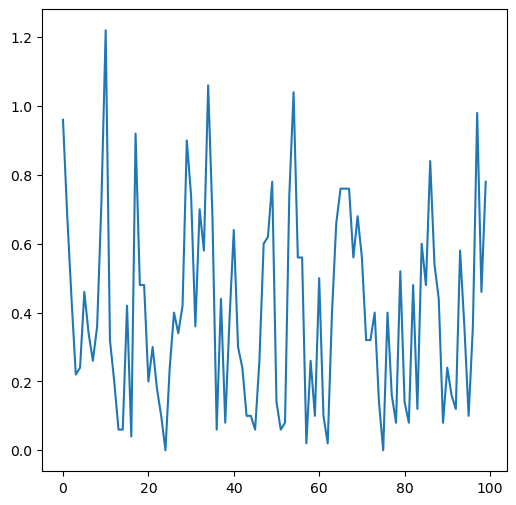

In [179]:
np.random.seed(42)

size=20
#initial_state = np.random.choice([-1, 1], size=size)
num_samples = 100
burnin = 0.2
num_iters = 100
#T = np.arange(1,20)

samples, initial_states, J, track_mag = metropolis_hastings(
    energy,
    proposed_sequence,
    size,
    num_samples,
    num_iters,
    burnin=burnin,
    T = 4
)

plt.figure(figsize=(6,6))
plt.plot(np.abs(track_mag.mean(axis=0)))

In [23]:
print("Number of chain: ", len(samples))
print("Length of a sequence: ", len(samples[0]))


Number of chain:  800
Length of a sequence:  200


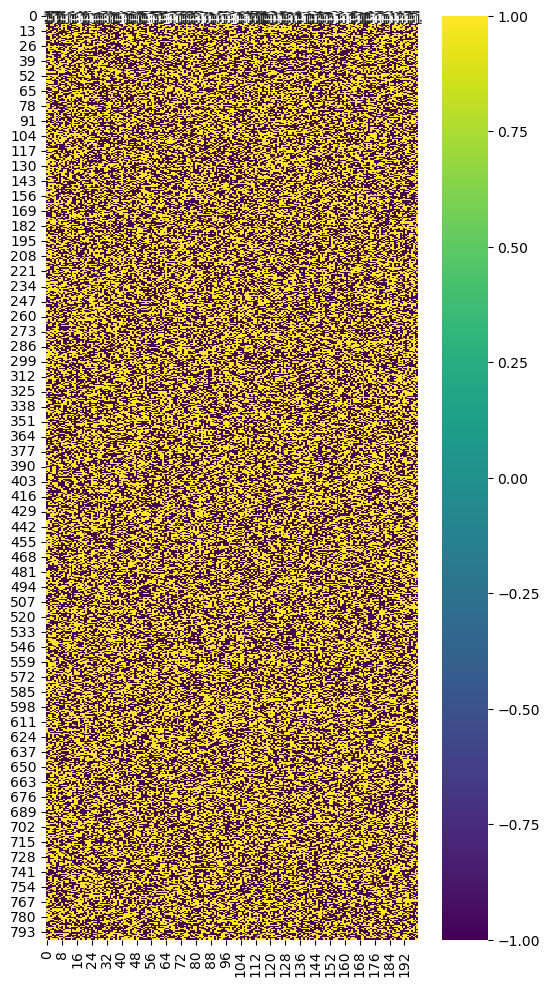

In [24]:
finalchains = np.vstack(samples)
plt.figure(figsize=(6,12))
sns.heatmap(finalchains, cmap='viridis', annot=True)
plt.show()


## Compute correlation matrix

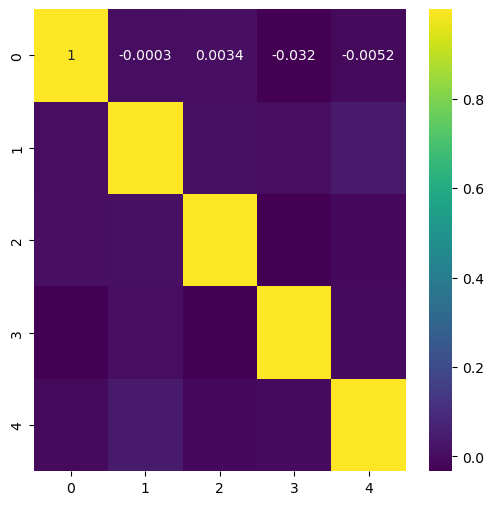

In [31]:
def ComputeCorrelationMatrix2(mat, pseudocount):
    
    nbr_spins, nbr_chains = len(samples[0]), len(samples)
    mat = np.array(mat,ndmin = 2, dtype = np.float64)
    average_spin = np.average(mat, axis = 0)[:,None]
    
    directcorr = np.dot(mat.T, mat)
    
    directcorr *= np.true_divide(1, nbr_chains, dtype = np.float64)
    
    correlation_matrix = np.dot(1.0-pseudocount, directcorr) - np.dot(pow(1-pseudocount,2),np.outer(average_spin.T, average_spin)) + np.dot(pseudocount,np.identity(nbr_spins))
    
    return correlation_matrix

correlation_matrix = ComputeCorrelationMatrix2(finalchains, 0.5)
plt.figure(figsize=(6,6))
sns.heatmap(correlation_matrix[:5,:5], cmap='viridis', annot=True)
plt.show()
#print(correlation_matrix)

## Covariances

## Mutual Information